## Plant functional trait uncertainty outweighs climate change uncertainty in tundra ecosystems
#### This notebook calculates annual fluxes using Community Land Model simulations of Niwot Ridge and partitions uncertainty between model experiments as described in the manuscript 'Plant functional trait uncertainty outweighs climate change uncertainty in tundra ecosystems'

### Load packages

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
from scipy import signal,stats
import cftime
import nc_time_axis
import dask
import functools
#import cf_units as cf

# some resources for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.dates as mdates

import matplotlib.colors as mcolors
from matplotlib.pyplot import cm

# suppress Runtime warnings that let you know when code isn't running too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
from distributed import wait

%matplotlib inline

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='4:00:00', # Amount of wall time
        interface='ext', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='2GB')
cluster.scale(5)

/glade/work/jayka/opt/miniconda/envs/ctsm-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46161 instead
  f"Port {expected} is already in use.\n"


In [4]:
cluster

### Read in CLM model output

#### First point to files

In [4]:
# Niwot LTER  simulations
# H1 files dimensioned time x column or time x pft
path = '/glade/derecho/scratch/jayka/archive/' # path to files
cases = ['NEON_NIWO_saddle_updated_snow_soils_H2OSFC_expt3_micro_sigma_trans','NEON_NIWO_saddle_updated_SSP370','NEON_NIWO_saddle_updated_TraitExp1.1_SSP370','NEON_NIWO_saddle_updated_TraitExp1.3_SSP370'] # case names

rollHour = -12  
years = range(2008,2022)
years2 = range(2022,2100)
years3 = range(2087,2100)
nmon = 12

# create a list of the files we'll open for each case
finSaddle = [path + cases[0] +'/lnd/hist/'+cases[0]+'.clm2.h1.'+str(years[i]) +'-01-01-00000.nc' \
           for i in range(len(years)) ]
finSadAnom = [path + cases[1] +'/lnd/hist/'+cases[1]+'.clm2.h1.'+str(years2[i]) +'-01-01-00000.nc' \
           for i in range(len(years2)) ]
finTraitExpt1 = [path + cases[2] +'/lnd/hist/'+cases[2]+'.clm2.h1.'+str(years2[i]) +'-01-01-00000.nc' \
           for i in range(len(years2)) ]
finTraitExpt2 = [path + cases[3] +'/lnd/hist/'+cases[3]+'.clm2.h1.'+str(years2[i]) +'-01-01-00000.nc' \
           for i in range(len(years2)) ]

# print the last year of data loaded
print(finSaddle[-1])

/glade/derecho/scratch/jayka/archive/NEON_NIWO_saddle_updated_snow_soils_H2OSFC_expt3_micro_sigma_trans/lnd/hist/NEON_NIWO_saddle_updated_snow_soils_H2OSFC_expt3_micro_sigma_trans.clm2.h1.2021-01-01-00000.nc


In [5]:
# Niwot LTER  simulations
# H1 files dimensioned time x column or time x pft
path = '/glade/derecho/scratch/jayka/archive/' # path to files
cases = ['NEON_NIWO_saddle_updated_snow_soils_H2OSFC_expt3_micro_sigma_trans','NEON_NIWO_saddle_updated_SSP245','NEON_NIWO_saddle_updated_TraitExp1.1_SSP245','NEON_NIWO_saddle_updated_TraitExp1.3_SSP245'] # case names

rollHour = -12  
years = range(2008,2022)
years2 = range(2022,2100)
nmon = 12

# create a list of the files we'll open for each case
finSaddle = [path + cases[0] +'/lnd/hist/'+cases[0]+'.clm2.h1.'+str(years[i]) +'-01-01-00000.nc' \
           for i in range(len(years)) ]
finSadAnomSSP = [path + cases[1] +'/lnd/hist/'+cases[1]+'.clm2.h1.'+str(years2[i]) +'-01-01-00000.nc' \
           for i in range(len(years2)) ]
finTraitExpt1SSP = [path + cases[2] +'/lnd/hist/'+cases[2]+'.clm2.h1.'+str(years2[i]) +'-01-01-00000.nc' \
           for i in range(len(years2)) ]
finTraitExpt2SSP = [path + cases[3] +'/lnd/hist/'+cases[3]+'.clm2.h1.'+str(years2[i]) +'-01-01-00000.nc' \
           for i in range(len(years2)) ]

In [6]:
# combine transient and forced cases
fileSaddle = finSaddle + finSadAnom
fileTraitExpt1 = finSaddle + finTraitExpt1
fileTraitExpt2 = finSaddle + finTraitExpt2

In [7]:
# combine transient and forced cases (load in anom years only)
fileSaddle = finSadAnom
fileTraitExpt1 = finTraitExpt1
fileTraitExpt2 = finTraitExpt2

In [8]:
# combine transient and forced cases
fileSaddle2 = finSaddle + finSadAnomSSP
fileSSP1 = finSaddle + finTraitExpt1SSP
fileSSP2 = finSaddle + finTraitExpt2SSP

In [9]:
# combine transient and forced cases (load in anom years only)
fileSaddle2 = finSadAnomSSP
fileSSP1 = finTraitExpt1SSP
fileSSP2 = finTraitExpt2SSP

#### Read in data with preprocessing

In [10]:
# define the history variables to read in
#fields = ['AGNPP','AR','BTRANMN','ELAI', 'FCEV','FCTR','FGEV','FIRA','FSA','FSR','FSH','FSDS','GPP','H2OSOI','HR','RAIN','SNOW','SNOW_DEPTH','TBOT','TSOI','QLATFLOWOUT','pft']
fields = ['AGNPP','AR','BTRANMN','ELAI','GPP','HR','TBOT','pft']

def preprocess(ds, fields):
    '''Selects the variables we want to read in'''
    
    return ds[fields]

# open the datasets -- two for each case
dsSad = xr.open_mfdataset(finSaddle, decode_times=True, 
                                 preprocess=functools.partial(preprocess, fields=fields))

dsSadAnom = xr.open_mfdataset(fileSaddle, decode_times=True, 
                                 preprocess=functools.partial(preprocess, fields=fields))

dsTraitExpt1 = xr.open_mfdataset(fileTraitExpt1, decode_times=True, 
                                 preprocess=functools.partial(preprocess, fields=fields))

dsTraitExpt2 = xr.open_mfdataset(fileTraitExpt2, decode_times=True, 
                                 preprocess=functools.partial(preprocess, fields=fields))

print('-- your data have been read in -- ')

-- your data have been read in -- 


In [11]:
# define the history variables to read in
#fields = ['AGNPP','AR','BTRANMN','ELAI', 'FCEV','FCTR','FGEV','FIRA','FSA','FSR','FSH','FSDS','GPP','H2OSOI','HR','RAIN','SNOW','SNOW_DEPTH','TBOT','TSOI','QLATFLOWOUT','pft']
fields = ['AGNPP','AR','BTRANMN','ELAI','GPP','HR','TBOT','pft']

def preprocess(ds, fields):
    '''Selects the variables we want to read in'''
    
    return ds[fields]

# open the datasets

dsSadAnomSSP = xr.open_mfdataset(fileSaddle2, decode_times=True, 
                                 preprocess=functools.partial(preprocess, fields=fields))

dsSSP1 = xr.open_mfdataset(fileSSP1, decode_times=True, 
                                 preprocess=functools.partial(preprocess, fields=fields))

dsSSP2 = xr.open_mfdataset(fileSSP2, decode_times=True, 
                                 preprocess=functools.partial(preprocess, fields=fields))

print('-- your data have been read in -- ')

-- your data have been read in -- 


In [12]:
# Combine pft and column coordinates
dsSad = dsSad.rename({'pft':'column'})
dsSadAnom = dsSadAnom.rename({'pft':'column'})
dsTraitExpt1 = dsTraitExpt1.rename({'pft':'column'})
dsTraitExpt2 = dsTraitExpt2.rename({'pft':'column'})

In [13]:
# Combine pft and column coordinates
dsSadSSP = dsSadAnomSSP.rename({'pft':'column'})
dsSSP1 = dsSSP1.rename({'pft':'column'})
dsSSP2 = dsSSP2.rename({'pft':'column'})

In [14]:
# select the desired columns and rename them
dsSad = dsSad.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})
dsSadAnom = dsSadAnom.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})
dsTraitExpt1 = dsTraitExpt1.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})
dsTraitExpt2 = dsTraitExpt2.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})

In [15]:
# select the desired columns and rename them
dsSadSSP = dsSadSSP.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})
dsSSP1 = dsSSP1.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})
dsSSP2 = dsSSP2.isel(column=[0,1,2]).assign_coords({"column": ["mm","wm", "dm"]})

In [16]:
# Combine CLM datasets using 'sim' dimension to allow sorting and plotting by case
ds1 = xr.concat([dsSadAnom,dsTraitExpt1,dsTraitExpt2], 'sim', data_vars='all')
ds1 = ds1.assign_coords(sim=("sim", ['control','acquis','cons']))

In [17]:
# Combine CLM datasets using 'sim' dimension to allow sorting and plotting by case
ds2 = xr.concat([dsSadSSP,dsSSP1,dsSSP2], 'sim', data_vars='all')
ds2 = ds2.assign_coords(sim=("sim", ['control','acquis','cons']))

In [18]:
# Combine SSP370 and SSP245 cases to create a dataset dimensioned by column, trait sim, and SSP
ds3 = xr.concat([ds1,ds2], 'expt', data_vars='all')
ds3 = ds3.assign_coords(expt=("expt", ['SSP370','SSP245']))

In [19]:
# For saving figs
#out_dir = '/glade/u/home/jayka/NWT_CLM_plots/traits_figs/'

#### Calculate annual GPP fluxes and uncertainty

In [20]:
# First convert CLM GPP units from g/m2/s to g/m2/y
ds3['GPP'] = ds3.GPP * 3600 * 24 * 365
ds3['GPP'].attrs['units'] = 'gC/m2/y'

In [2]:
#ds3.GPP.values

In [27]:
# calculate annual mean GPP for each expt x forcing combination (6 total)
annGPP_ctrl_370 = ds3.GPP.sel(sim='control',expt='SSP370').groupby(ds3['time.year']).mean()
annGPP_acquis_370 = ds3.GPP.sel(sim='acquis',expt='SSP370').groupby(ds3['time.year']).mean()
annGPP_cons_370 = ds3.GPP.sel(sim='cons',expt='SSP370').groupby(ds3['time.year']).mean()
annGPP_ctrl_245 = ds3.GPP.sel(sim='control',expt='SSP245').groupby(ds3['time.year']).mean()
annGPP_acquis_245 = ds3.GPP.sel(sim='acquis',expt='SSP245').groupby(ds3['time.year']).mean()
annGPP_cons_245 = ds3.GPP.sel(sim='cons',expt='SSP245').groupby(ds3['time.year']).mean() 

In [28]:
# calculate multi model mean GPP for each forcing scenario
x_370 = np.mean([annGPP_ctrl_370, annGPP_acquis_370, annGPP_cons_370], axis=0)
x_245 = np.mean([annGPP_ctrl_245, annGPP_acquis_245, annGPP_cons_245], axis=0)

In [29]:
# calculate multi model variance for each forcing scenario
s2_370 = np.var([annGPP_ctrl_370, annGPP_acquis_370, annGPP_cons_370], axis=0)
s2_245 = np.var([annGPP_ctrl_245, annGPP_acquis_245, annGPP_cons_245], axis=0)

In [30]:
# total uncertainty: variance of multi-model ensemble
s2_total = np.var([annGPP_ctrl_370, annGPP_acquis_370, annGPP_cons_370, annGPP_ctrl_245, annGPP_acquis_245, annGPP_cons_245], axis=0)

In [31]:
# climate uncertainty: variance of multi model means for each forcing scenario
s2_clim = np.var([x_370, x_245], axis=0)

In [32]:
# model uncertainty: mean of multi model variance for each forcing scenario
s2_trait = np.mean([s2_370, s2_245], axis=0)

In [33]:
# calculate proportional uncertainty (trait, forcing out of total)
s2_clim_prop = s2_clim/s2_total
s2_trait_prop = s2_trait/s2_total

#### Calculate annual AGNPP fluxes and uncertainty

In [42]:
# First convert CLM AGNPP units from g/m2/s to g/m2/y
ds3['AGNPP'] = ds3.AGNPP * 3600 * 24 * 365
ds3['AGNPP'].attrs['units'] = 'gC/m2/y'

In [43]:
# calculate annual mean AGNPP for each expt x forcing combination (6 total)
annAGNPP_ctrl_370 = ds3.AGNPP.sel(sim='control',expt='SSP370').groupby(ds3['time.year']).mean()
annAGNPP_acquis_370 = ds3.AGNPP.sel(sim='acquis',expt='SSP370').groupby(ds3['time.year']).mean()
annAGNPP_cons_370 = ds3.AGNPP.sel(sim='cons',expt='SSP370').groupby(ds3['time.year']).mean()
annAGNPP_ctrl_245 = ds3.AGNPP.sel(sim='control',expt='SSP245').groupby(ds3['time.year']).mean()
annAGNPP_acquis_245 = ds3.AGNPP.sel(sim='acquis',expt='SSP245').groupby(ds3['time.year']).mean()
annAGNPP_cons_245 = ds3.AGNPP.sel(sim='cons',expt='SSP245').groupby(ds3['time.year']).mean() 

In [44]:
# calculate multi model mean AGNPP for each forcing scenario
x_370_AGNPP = np.mean([annAGNPP_ctrl_370, annAGNPP_acquis_370, annAGNPP_cons_370], axis=0)
x_245_AGNPP = np.mean([annAGNPP_ctrl_245, annAGNPP_acquis_245, annAGNPP_cons_245], axis=0)

In [45]:
# calculate multi model variance for each forcing scenario
s2_370_AGNPP = np.var([annAGNPP_ctrl_370, annAGNPP_acquis_370, annAGNPP_cons_370], axis=0)
s2_245_AGNPP = np.var([annAGNPP_ctrl_245, annAGNPP_acquis_245, annAGNPP_cons_245], axis=0)

In [46]:
# total uncertainty: variance of multi-model ensemble
s2_total_AGNPP = np.var([annAGNPP_ctrl_370, annAGNPP_acquis_370, annAGNPP_cons_370, annAGNPP_ctrl_245, annAGNPP_acquis_245, annAGNPP_cons_245], axis=0)

In [47]:
# climate uncertainty: variance of multi model means for each forcing scenario
s2_clim_AGNPP = np.var([x_370_AGNPP, x_245_AGNPP], axis=0)

In [48]:
# model uncertainty: mean of multi model variance for each forcing scenario
s2_trait_AGNPP = np.mean([s2_370_AGNPP, s2_245_AGNPP], axis=0)

In [49]:
# calculate proportional uncertainty (trait, forcing out of total)
s2_clim_prop_AGNPP = s2_clim_AGNPP/s2_total_AGNPP
s2_trait_prop_AGNPP = s2_trait_AGNPP/s2_total_AGNPP

### Plotting uncertainty in carbon cycle metrics 
#### First GPP, then ANPP (Figure 6)

In [61]:
#mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["tab:green", "tab:blue", "tab:orange"]) 

In [ ]:
# create a dataset of uncertainty values by community

In [50]:
col_names = ['MM_s2_trait','WM_s2_trait','DM_s2_trait']
row_names = np.arange(2022, 2100)
ds_s2_trait = pd.DataFrame(s2_trait,  index=row_names, columns=col_names)


In [51]:
col_names = ['MM_s2_clim','WM_s2_clim','DM_s2_clim']
row_names = np.arange(2022, 2100)
ds_s2_clim = pd.DataFrame(s2_clim,  index=row_names, columns=col_names)

In [52]:
col_names = ['MM_s2_total','WM_s2_total','DM_s2_total']
row_names = np.arange(2022, 2100)
ds_s2_total = pd.DataFrame(s2_total,  index=row_names, columns=col_names)

In [53]:
col_names = ['MM_s2_clim_prop','WM_s2_clim_prop','DM_s2_clim_prop']
row_names = np.arange(2022, 2100)
ds_s2_clim_prop = pd.DataFrame(s2_clim_prop,  index=row_names, columns=col_names)

In [54]:
col_names = ['MM_s2_trait_prop','WM_s2_trait_prop','DM_s2_trait_prop']
row_names = np.arange(2022, 2100)
ds_s2_trait_prop = pd.DataFrame(s2_trait_prop,  index=row_names, columns=col_names)

In [55]:
ds = pd.concat([ds_s2_total, ds_s2_trait, ds_s2_clim, ds_s2_clim_prop, ds_s2_trait_prop], axis=1)

In [39]:
ds

,MM_s2_total,WM_s2_total,DM_s2_total,MM_s2_trait,WM_s2_trait,DM_s2_trait,MM_s2_clim,WM_s2_clim,DM_s2_clim,MM_s2_clim_prop,WM_s2_clim_prop,DM_s2_clim_prop,MM_s2_trait_prop,WM_s2_trait_prop,DM_s2_trait_prop
2022,84.439064,63.029316,346.633179,76.551430,2.617137,346.624268,7.887642,60.412334,0.008937,0.093412,0.958480,0.000026,0.906588,0.041523,0.999974
2023,199.358383,523.607056,1169.271118,173.137115,57.788315,1169.020508,26.221226,465.817017,0.250473,0.131528,0.889631,0.000214,0.868472,0.110366,0.999786
2024,493.947388,390.404938,2287.291992,474.925781,200.628998,2285.679199,19.021450,189.777359,1.613105,0.038509,0.486104,0.000705,0.961491,0.513900,0.999295
2025,326.589752,453.726562,2913.322021,294.596039,309.195007,2909.633301,31.993683,144.531494,3.688679,0.097963,0.318543,0.001266,0.902037,0.681457,0.998734
2026,1255.640869,1789.203979,5307.049316,1233.411743,1786.118164,5302.118164,22.229031,3.085615,4.931726,0.017703,0.001725,0.000929,0.982297,0.998275,0.999071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,3980.453857,15841.703125,7514.561035,1008.788757,1355.895874,5044.172852,2971.665527,14485.798828,2470.388428,0.746565,0.914409,0.328747,0.253436,0.085590,0.671253
2096,9430.768555,16632.398438,11698.210938,2702.117188,2992.962891,7743.412598,6728.650391,13639.435547,3954.798828,0.713479,0.820052,0.338069,0.286521,0.179948,0.661931
2097,7383.058594,7624.615234,9838.573242,2551.650391,2302.633301,6767.608398,4831.408203,5321.984863,3070.963623,0.654391,0.698000,0.312135,0.345609,0.302000,0.687865
2098,10134.507812,14587.417969,11790.678711,2690.981689,2255.114746,7556.276855,7443.524414,12332.302734,4234.403809,0.734473,0.845407,0.359131,0.265527,0.154593,0.640869


In [56]:
plt.rcParams.update({'font.size': 18})

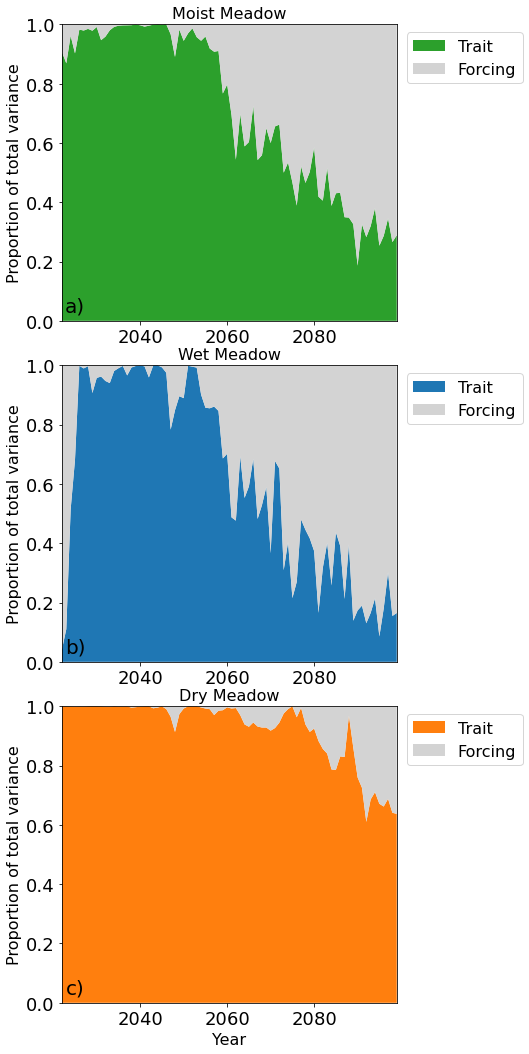

In [36]:
x=np.arange(2022, 2100)

y1=ds.MM_s2_trait_prop
y2=ds.MM_s2_clim_prop

y3=ds.WM_s2_trait_prop
y4=ds.WM_s2_clim_prop

y5=ds.DM_s2_trait_prop
y6=ds.DM_s2_clim_prop

fig, axs = plt.subplots(3, 1,  gridspec_kw={'wspace': 0.15, 'hspace': 0.15}, figsize=(6,18))

plt.subplot(3,1,1)
plt.title('Moist Meadow', fontsize=16)
plt.stackplot(x, y1, y2, colors =['tab:green','lightgray'], labels = ['Trait','Forcing']);
plt.ylabel('Proportion of total variance', fontsize=16) 
plt.legend(fontsize=16,loc='upper right',bbox_to_anchor=(1.4, 1));
plt.annotate('a)', xy=(2025, 0.05), 
                ha='center', va='center',size=20) ;
plt.xlim([2022, 2099]);
plt.ylim([0, 1]);

plt.subplot(3,1,2)
plt.title('Wet Meadow', fontsize=16)
plt.stackplot(x, y3, y4, colors =['tab:blue','lightgray'], labels = ['Trait','Forcing']);
plt.ylabel('Proportion of total variance', fontsize=16) 
plt.legend(fontsize=16,loc='upper right',bbox_to_anchor=(1.4, 1));
plt.annotate('b)', xy=(2025, 0.05), 
                ha='center', va='center',size=20) ;
plt.xlim([2022, 2099]);
plt.ylim([0, 1]);

plt.subplot(3,1,3)
plt.title('Dry Meadow', fontsize=16)
plt.stackplot(x, y5, y6, colors =['tab:orange','lightgray'], labels = ['Trait','Forcing']);
plt.ylabel('Proportion of total variance', fontsize=16) 
plt.legend(fontsize=16,loc='upper right',bbox_to_anchor=(1.4, 1));
plt.xlabel('Year', fontsize=16) 
plt.annotate('c)', xy=(2025, 0.05), 
                ha='center', va='center',size=20) ;
plt.xlim([2022, 2099]);
plt.ylim([0, 1]);
     
    #axs[i].annotate(panel2[i], xy=(0.05, 27), 
     #           ha='center', va='center',fontsize=16)  
#plt.savefig(out_dir+'Fig6a.pdf', bbox_inches='tight');

In [ ]:
# do the same for ANPP

In [45]:
col_names_AGNPP = ['MM_s2_trait_AGNPP','WM_s2_trait_AGNPP','DM_s2_trait_AGNPP']
row_names_AGNPP = np.arange(2022, 2100)
ds_s2_trait_AGNPP = pd.DataFrame(s2_trait_AGNPP,  index=row_names_AGNPP, columns=col_names_AGNPP)


In [46]:
col_names_AGNPP = ['MM_s2_clim_AGNPP','WM_s2_clim_AGNPP','DM_s2_clim_AGNPP']
row_names_AGNPP = np.arange(2022, 2100)
ds_s2_clim_AGNPP = pd.DataFrame(s2_clim_AGNPP,  index=row_names_AGNPP, columns=col_names_AGNPP)

In [47]:
col_names_AGNPP = ['MM_s2_total_AGNPP','WM_s2_total_AGNPP','DM_s2_total_AGNPP']
row_names_AGNPP = np.arange(2022, 2100)
ds_s2_total_AGNPP = pd.DataFrame(s2_total_AGNPP,  index=row_names_AGNPP, columns=col_names_AGNPP)

In [48]:
col_names_AGNPP = ['MM_s2_clim_prop_AGNPP','WM_s2_clim_prop_AGNPP','DM_s2_clim_prop_AGNPP']
row_names_AGNPP = np.arange(2022, 2100)
ds_s2_clim_prop_AGNPP = pd.DataFrame(s2_clim_prop_AGNPP,  index=row_names_AGNPP, columns=col_names_AGNPP)

In [49]:
col_names_AGNPP = ['MM_s2_trait_prop_AGNPP','WM_s2_trait_prop_AGNPP','DM_s2_trait_prop_AGNPP']
row_names_AGNPP = np.arange(2022, 2100)
ds_s2_trait_prop_AGNPP = pd.DataFrame(s2_trait_prop_AGNPP,  index=row_names_AGNPP, columns=col_names_AGNPP)

In [50]:
ds_AGNPP = pd.concat([ds_s2_total_AGNPP, ds_s2_trait_AGNPP, ds_s2_clim_AGNPP, ds_s2_clim_prop_AGNPP, ds_s2_trait_prop_AGNPP], axis=1)

In [52]:
ds_AGNPP

,MM_s2_total_AGNPP,WM_s2_total_AGNPP,DM_s2_total_AGNPP,MM_s2_trait_AGNPP,WM_s2_trait_AGNPP,DM_s2_trait_AGNPP,MM_s2_clim_AGNPP,WM_s2_clim_AGNPP,DM_s2_clim_AGNPP,MM_s2_clim_prop_AGNPP,WM_s2_clim_prop_AGNPP,DM_s2_clim_prop_AGNPP,MM_s2_trait_prop_AGNPP,WM_s2_trait_prop_AGNPP,DM_s2_trait_prop_AGNPP
2022,0.000005,0.000039,7.595693e-07,0.000000,8.003553e-09,1.438821e-09,0.000005,0.000039,7.597882e-07,0.999997,0.999389,1.000288,0.000000,0.000205,0.001894
2023,1.339563,14.189656,1.451080e+00,1.284540,1.389794e+01,1.450907e+00,0.055024,0.291720,1.724018e-04,0.041076,0.020559,0.000119,0.958924,0.979442,0.999881
2024,1.584359,24.781693,7.725769e+00,1.283015,2.110329e+01,7.720065e+00,0.301342,3.678414,5.703204e-03,0.190198,0.148433,0.000738,0.809801,0.851568,0.999262
2025,0.569256,17.507999,1.337433e+01,0.253589,1.368180e+01,1.334044e+01,0.315669,3.826210,3.389041e-02,0.554528,0.218541,0.002534,0.445474,0.781460,0.997466
2026,0.519771,8.571170,2.282887e+01,0.030904,6.235298e+00,2.276048e+01,0.488867,2.335856,6.838793e-02,0.940543,0.272525,0.002996,0.059458,0.727473,0.997004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,33.730972,224.078003,2.718390e+01,2.861120,3.214546e+00,1.549532e+01,30.869854,220.863373,1.168857e+01,0.915178,0.985654,0.429982,0.084822,0.014346,0.570018
2096,65.827393,302.267700,4.160683e+01,2.224003,7.438395e-01,1.962080e+01,63.603371,301.523682,2.198602e+01,0.966214,0.997539,0.528423,0.033785,0.002461,0.471577
2097,67.494476,255.394394,6.304799e+01,2.544968,1.415210e+00,3.028931e+01,64.949509,253.979218,3.275866e+01,0.962294,0.994459,0.519583,0.037706,0.005541,0.480417
2098,63.261211,152.543625,6.566724e+01,4.154638,6.903850e-01,3.298544e+01,59.106571,151.853363,3.268181e+01,0.934326,0.995475,0.497688,0.065674,0.004526,0.502312


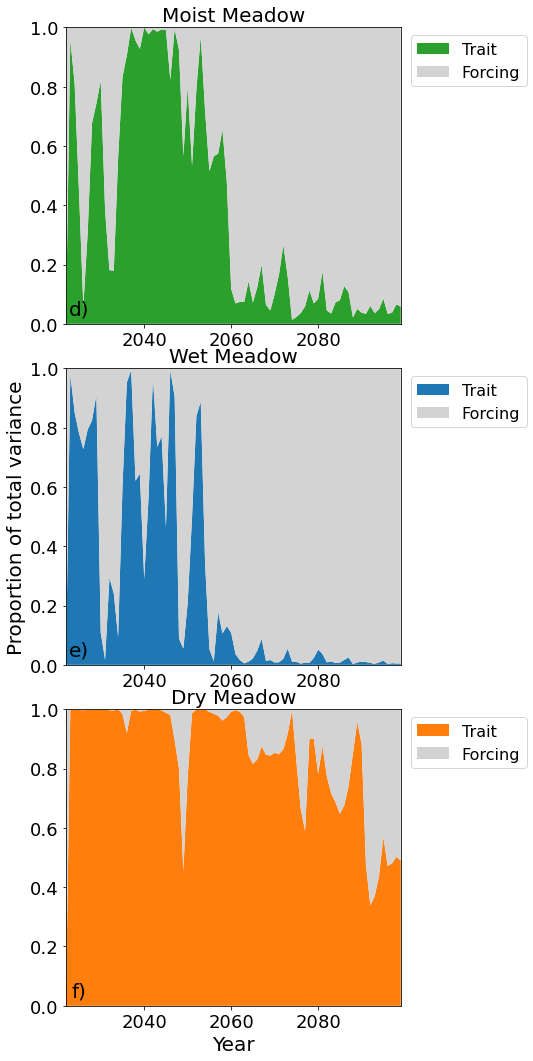

In [51]:
x=np.arange(2022, 2100)

y1=ds_AGNPP.MM_s2_trait_prop_AGNPP
y2=ds_AGNPP.MM_s2_clim_prop_AGNPP

y3=ds_AGNPP.WM_s2_trait_prop_AGNPP
y4=ds_AGNPP.WM_s2_clim_prop_AGNPP

y5=ds_AGNPP.DM_s2_trait_prop_AGNPP
y6=ds_AGNPP.DM_s2_clim_prop_AGNPP

fig, axs = plt.subplots(3, 1,  gridspec_kw={'wspace': 0.15, 'hspace': 0.15}, figsize=(6,18))

plt.subplot(3,1,1)
plt.title('Moist Meadow', fontsize=20)
plt.stackplot(x, y1, y2, colors =['tab:green','lightgray'], labels = ['Trait','Forcing']);
plt.annotate('d)', xy=(2025, 0.05), 
                ha='center', va='center',size=20) 
plt.legend(fontsize=16,loc='upper right',bbox_to_anchor=(1.4, 1));
plt.xlim([2022, 2099]);
plt.ylim([0, 1]);

plt.subplot(3,1,2)
plt.title('Wet Meadow', fontsize=20)
plt.stackplot(x, y3, y4, colors =['tab:blue','lightgray'], labels = ['Trait','Forcing']);
plt.ylabel('Proportion of total variance', fontsize=20) 
plt.annotate('e)', xy=(2025, 0.05), 
                ha='center', va='center',size=20) 
plt.legend(fontsize=16,loc='upper right',bbox_to_anchor=(1.4, 1));
plt.xlim([2022, 2099]);
plt.ylim([0, 1]);

plt.subplot(3,1,3)
plt.title('Dry Meadow', fontsize=20)
plt.stackplot(x, y5, y6, colors =['tab:orange','lightgray'], labels = ['Trait','Forcing']);
plt.legend(fontsize=16,loc='upper right',bbox_to_anchor=(1.4, 1));
plt.xlabel('Year', fontsize=20) 
plt.annotate('f)', xy=(2025, 0.05), 
                ha='center', va='center',size=20) 
plt.xlim([2022, 2099]);
plt.ylim([0, 1]);

#plt.savefig(out_dir+'Fig6b.pdf', bbox_inches='tight');